# HW11 Assignment I - Data wrangling and geopandas

This notebook presents an excersise in data wranging and spatial visualization using geopandas and shapely. The notebook is based on the PUI 2016 HW 11 notebook by fedhere. The main work on this notebook instance was:

1) To Find the census trck shape files online and do some filtering (get only the Brooklyn shape polygons)

2) to Find the coordinates of CUSP: 1 MetroTech Brooklyn and Create a Point shapely geometry with it.

3) to loop over the previously filtered Brooklyn polygons and find in which geometry the 1 Metro Tech point is contained

4) To plot one every 10 polygons of brooklyn and overplot the location of cusp as a point along with the census block that contains cusp in red

In [1]:
# Imports to work with with statistical analysis, maps, etc.

%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import ast
from cStringIO import StringIO
import os
import json
import requests
import urllib2
import urllib
import shapely
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
pl.rcParams.update(data)
pl.rcParams['font.size']=12

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [47]:
# Find the census trck shape files
# Will download this directly from the american fact finder Site
# https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml

fileUrl = 'http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip'

print (fileUrl)
os.system("curl -o nycb2010_16d.zip " + fileUrl)
os.system("mv nycb2010_16d.zip " + os.getenv("PUIDATA") + "/NYCZIPS/")
os.system("unzip " + os.getenv("PUIDATA") + "/NYCZIPS/nycb2010_16d.zip"\
         " -d " + os.getenv("PUIDATA") + "/NYCZIPS/")

http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip


0

In [54]:
# Load the census data into a geopandas DF

filePath = os.getenv("PUIDATA") + "/NYCZIPS/nycb2010_16d/nycb2010.shp"
ct_shape = GeoDataFrame.from_file(filePath)

# Extract only the Brooklyn shape polygons
ct_latlon = ct_shape[ct_shape.BoroName == 'Brooklyn']

# Convert the coordinates to lat/lon
ct_latlon = ct_latlon.to_crs(epsg=4326)

ct_latlon.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5037,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,"POLYGON ((-74.00659158337982 40.6556127336851,..."
5038,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384570529...
5039,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,"POLYGON ((-73.99270830309769 40.6980992598468,..."
5040,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,"POLYGON ((-73.9851430608965 40.69488514300315,..."
5041,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,POLYGON ((-73.98305147125492 40.69837793357372...


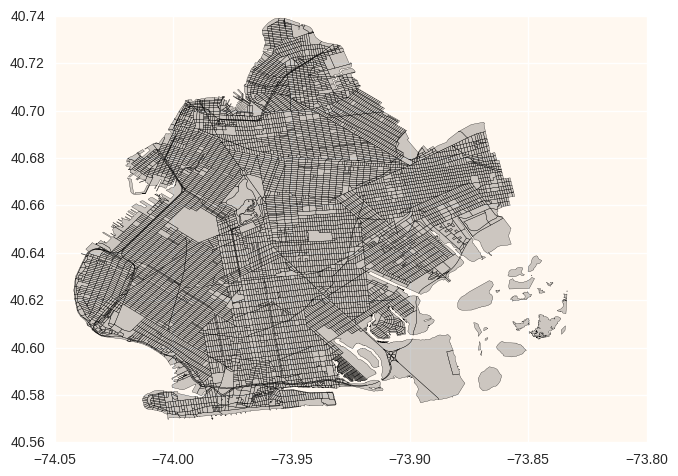

In [81]:
# Plot Bklyn based on the filtered geodataframe
ct_latlon.plot(color='k', alpha=0.2, linewidth=0.2)

              Figure I: Map of Brooklyn divided by census blocks

In [56]:
# Find the coordinates of CUSP: 1 MetroTech Brooklyn and Create a Point shapely geometry with the coordinates of CUSP
# From google maps: 1 MetroTech is -73.986446, 40.693298

CUSPPoint = shapely.geometry.Point(-73.986446, 40.693298)
len(ct_latlon)

9682

In [57]:
# Loop over the Brookly polygons and find in which geometry the polygon is contained

for ind in ct_latlon.index:
    geom = ct_latlon.geometry.loc[ind]
    if shapely.geometry.asShape(geom).contains(CUSPPoint):
        cuspind = ind # Record the index of the tract that contains the coordinate
        print("CUSP is contained in poligon", str(geom))

('CUSP is contained in poligon', 'POLYGON ((-73.98619262163142 40.69375351897136, -73.98621117787486 40.6933838601358, -73.98622595691906 40.69308831343839, -73.98725396415627 40.69312490276504, -73.98722751058244 40.69379951953569, -73.98619262163142 40.69375351897136))')


38792


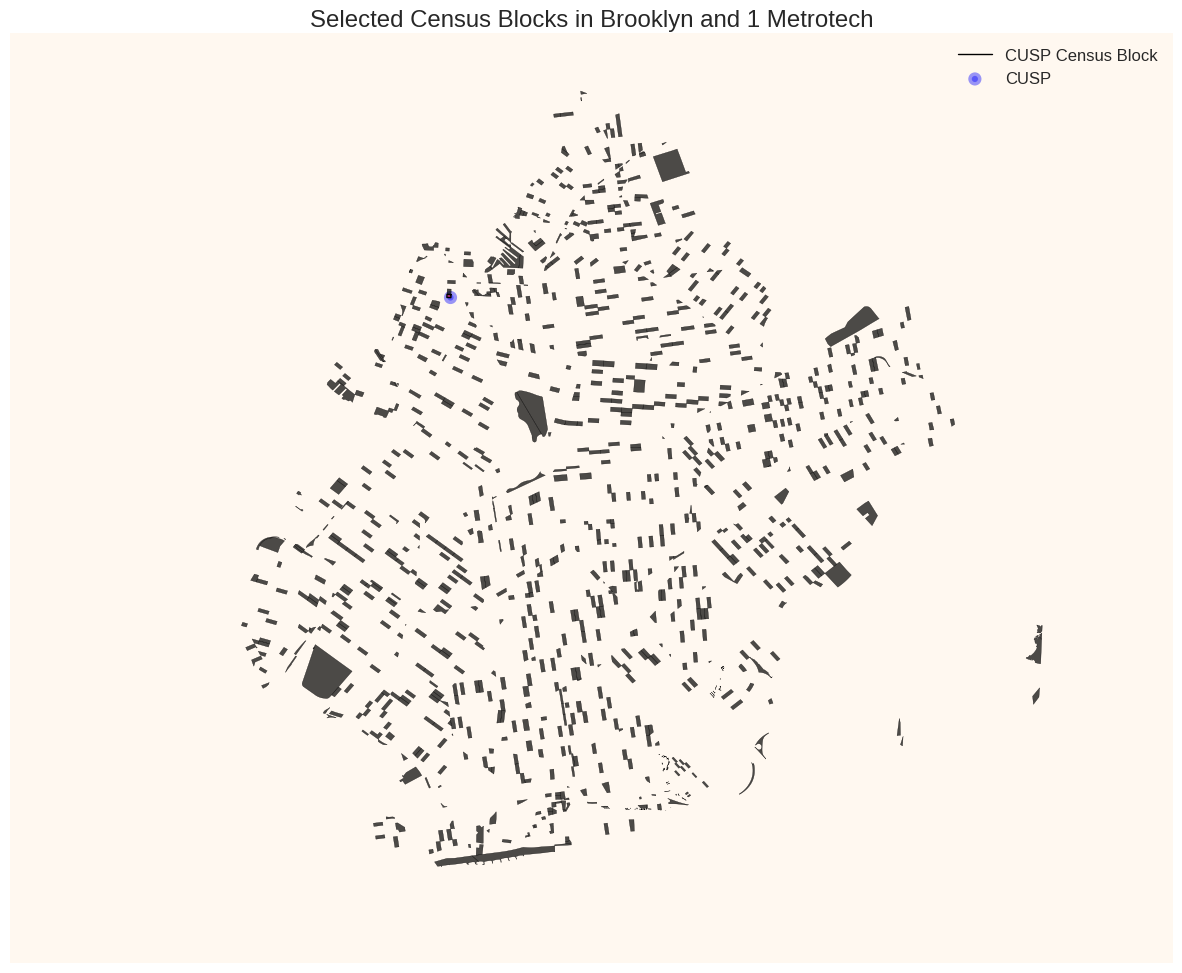

In [79]:
f, ax = pl.subplots(figsize=(15, 12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#ct_latlon.plot(color="grey", ax=ax, alpha=.5)
ct_latlon.iloc[::10].plot(color='k', ax=ax, alpha=0.7, linewidth=0.2)

# Select the row from the GeoDataFrame containing the tract block identified above
cusp_shape = GeoDataFrame(ct_latlon.loc[cuspind])
cusp_shape.transpose().plot(color='red', ax=ax, label = "CUSP Census Block", linewidth=1)
pl.scatter(CUSPPoint.x, CUSPPoint.y, color='blue', alpha=0.4, label='CUSP', linewidths=5)
pl.title("Selected Census Blocks in Brooklyn and 1 Metrotech")
pl.legend()

print (ind)

Figure II: Map of Brooklyn displaying 1 of each 10 census blocks. The Blue dot represents the Metrotech 1 building, and the colored block represents the census block where the builing is